# 180日間のデータを入力として、異常値を検知する

In [1]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [35]:
data = pd.read_csv('weather/data.csv' ,skiprows=[0,1,2,4] ,encoding='shift-jis')

In [36]:
temp_data=data['平均気温(℃)']

In [37]:
temp_data

0       6.2
1       4.5
2       2.5
3       4.1
4       3.9
       ... 
2187    5.5
2188    4.7
2189    5.5
2190    6.6
2191    4.4
Name: 平均気温(℃), Length: 2192, dtype: float64

# データのチェック

In [38]:
data[1820:1830]

,年月日,平均気温(℃),平均気温(℃).1,平均気温(℃).2
1820,2018/12/26,5.9,8,1
1821,2018/12/27,7.2,8,1
1822,2018/12/28,3.5,8,1
1823,2018/12/29,3.2,8,1
1824,2018/12/30,3.6,8,1
1825,2018/12/31,3.4,8,1
1826,2019/1/1,4.7,8,1
1827,2019/1/2,3.8,8,1
1828,2019/1/3,3.3,8,1
1829,2019/1/4,4.2,8,1


In [39]:
train_x=temp_data[:1826]
test_x=temp_data[1826:]
train_x=np.array(train_x)
test_x=np.array(test_x)

In [40]:
train_x

array([6.2, 4.5, 2.5, ..., 3.2, 3.6, 3.4])

In [41]:
len(train_x)

1826

In [42]:
test_x

array([ 4.7,  3.8,  3.3,  4.2,  6.1,  3.6,  4.1,  3.1,  3.3,  0.2,  5.4,
        3. ,  4.7,  2.6,  1.9,  4.7,  4.7,  4. ,  4.8,  4.9,  4. ,  2.9,
        3.8,  4.8,  4.3,  3.4,  3.2,  2.9,  4.7,  3. ,  3.6,  2.9,  4.2,
        5.9,  8.8,  5.1,  4.7,  6.7,  3.6, -0.3,  2.3,  1.5,  4.4,  4. ,
        2.8,  1.8,  4.9,  5.3,  6.3,  6.7, 10.6,  8.3,  6.9,  7.2,  6.2,
        9.4,  8.9,  6.5,  6.3,  7.9,  8.5,  5.5,  7.1,  8.7,  8.7,  7.4,
        5.5,  7.9, 10.3, 10.8,  9.9,  9.4,  6. ,  7.1,  7.5,  6.9,  7.9,
       10.3, 13.4, 15.4, 13.1,  5.9,  6. ,  8.2, 10.8, 12.9, 11.3,  7. ,
        7.3,  9.1,  7.4,  6. ,  6.5,  9. , 13.5, 14. , 14. ,  8.2,  9.1,
        3.5,  9.1,  8.3, 10.8, 13. , 14.6, 13.9, 13.2, 15.9, 16.7, 13.7,
       15.9, 18.5, 17.9, 17.3, 20. , 11.6, 10. , 12. , 13.9, 13.7, 17. ,
       17.2, 17.1, 16.2, 17.1, 17.2, 13.7, 15. , 16.3, 19.3, 19.8, 17.2,
       17.3, 17. , 18.1, 18.6, 19.1, 18.6, 19.4, 18.6, 18.4, 18.3, 20.1,
       21.4, 23. , 23.9, 24.8, 22.4, 20.3, 20.2, 20

In [43]:
len(test_x)

366

In [45]:
# ミニバッチ用のデータを作る
window_size=180
tmp= []
train_X=[]

for i in range(0 , len(train_x)-window_size):
    tmp.append(train_x[i:i+window_size])

train_X=np.array(tmp)

In [46]:
pd.DataFrame(train_X)

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,6.2,4.5,2.5,4.1,3.9,2.6,2.5,4.0,5.0,1.3,...,22.1,23.1,20.2,22.2,20.7,20.9,22.5,22.4,21.0,22.0
1,4.5,2.5,4.1,3.9,2.6,2.5,4.0,5.0,1.3,2.0,...,23.1,20.2,22.2,20.7,20.9,22.5,22.4,21.0,22.0,22.0
2,2.5,4.1,3.9,2.6,2.5,4.0,5.0,1.3,2.0,2.7,...,20.2,22.2,20.7,20.9,22.5,22.4,21.0,22.0,22.0,23.6
3,4.1,3.9,2.6,2.5,4.0,5.0,1.3,2.0,2.7,2.5,...,22.2,20.7,20.9,22.5,22.4,21.0,22.0,22.0,23.6,24.2
4,3.9,2.6,2.5,4.0,5.0,1.3,2.0,2.7,2.5,2.2,...,20.7,20.9,22.5,22.4,21.0,22.0,22.0,23.6,24.2,22.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,28.4,27.4,28.2,28.0,27.5,27.4,20.7,22.9,26.2,26.7,...,6.3,7.6,6.3,7.2,6.9,8.2,9.0,6.3,3.5,5.9
1642,27.4,28.2,28.0,27.5,27.4,20.7,22.9,26.2,26.7,27.5,...,7.6,6.3,7.2,6.9,8.2,9.0,6.3,3.5,5.9,7.2
1643,28.2,28.0,27.5,27.4,20.7,22.9,26.2,26.7,27.5,28.1,...,6.3,7.2,6.9,8.2,9.0,6.3,3.5,5.9,7.2,3.5
1644,28.0,27.5,27.4,20.7,22.9,26.2,26.7,27.5,28.1,25.6,...,7.2,6.9,8.2,9.0,6.3,3.5,5.9,7.2,3.5,3.2


# モデルの定義

In [90]:
# Module を継承して、Netクラスを作成する
class Net(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net, self).__init__()
        # nn.Linear (入力のノード数 , 出力ノード数)　：４階層
        self.fc1=nn.Linear(180 , 128)
        self.fc2=nn.Linear(128 , 64)
        self.fc3=nn.Linear(64 , 128)
        self.fc4=nn.Linear(128 , 180)
    
    # ニューラルネットワークを通して、出力値を求める関数
    def forward(self ,x):
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        x=F.relu(self.fc3(x))
        x=self.fc4(x)
        return x
    
model=Net()

# トレーニングの実行

In [91]:
#平均二乗和誤差
criterion = nn.MSELoss()
#勾配降下法の１つ　動的に学習率を変更して収束しやすくする　ＳＧＤやＡｄａＧｒａｄなどの改良版
optimizer = optim.Adam(model.parameters() ,lr=0.002)

# トレーニングの回数分ループする。（今回は1000回）
for epoch in range(4000):
    total_loss=0
    input_x=[]
    
    # データの件数のうち、１００回分ループする。
    for i in range(100):
        #100回ループするなかで、ランダムでデータを取得する
        index= np.random.randint(0,len(train_X)-1)
        input_x.append(train_X[index])
    
    # ランダムに取得した入力データを設定する
    input_x=np.array(input_x , dtype='float32')
    input_x=Variable(torch.from_numpy(input_x))
    
    # オプティマイザーの初期化
    optimizer.zero_grad()
    # 結果の計算
    output = model(input_x)
    # 損失の計算 (出力の結果；output と 正解：train_yを渡す)
    loss=criterion(output ,input_x)
    # ロスを伝播する
    loss.backward()
    # パラメータを更新する
    optimizer.step()
    # トータルロスを格納
    total_loss += loss.item()
    
    if (epoch+1) % 200 == 0:
        print(epoch+1 ,total_loss)

200 5.2676496505737305
400 5.154002666473389
600 5.163513660430908
800 4.602463245391846
1000 4.433287620544434
1200 4.156716346740723
1400 3.9055399894714355
1600 3.8023037910461426
1800 3.282635450363159
2000 3.4245338439941406
2200 3.073087215423584
2400 2.8981375694274902
2600 2.9740493297576904
2800 2.7253072261810303
3000 2.6684954166412354
3200 2.5986692905426025
3400 2.705308675765991
3600 2.423597812652588
3800 2.3607215881347656
4000 2.2782814502716064


# matplotlibで描画する

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


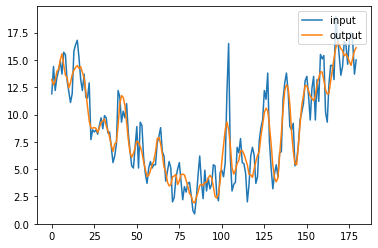

In [93]:
plt.plot(input_x.data[0].numpy() , label='input')
plt.plot(output.data[0].numpy() , label='output')
plt.legend(loc='upper right')


# 異常値の検知をする (テストデータで計算する）

In [96]:
# テスト用のデータを作る
input_x=[]
test_X=[]

input_x.append(test_x[0:180])
input_x.append(test_x[180:360])

test_X = np.array(input_x ,dtype='float32')
pd.DataFrame(test_X)

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,4.700000,3.8,3.300000,4.2,6.100000,3.6,4.1,3.1,3.3,0.2,...,23.0,23.1,21.200001,20.0,18.6,21.6,23.5,24.200001,24.5,19.5
1,21.299999,22.4,23.299999,24.0,21.200001,21.1,20.5,18.9,19.9,18.6,...,7.0,9.9,7.500000,9.0,6.5,5.3,5.7,6.500000,3.5,6.5


In [98]:
# テスト用のデータに対して、検証結果
input_test = Variable(torch.from_numpy(test_X))
output = model(input_test)

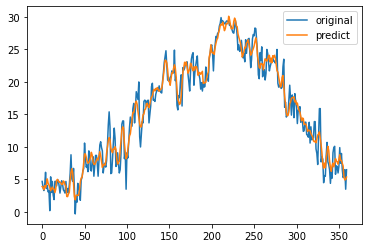

In [102]:
plt.plot(test_X.flatten() , label='original')
plt.plot(output.data.numpy().flatten() , label='predict')
plt.legend(loc='upper right')

# 異常値の検知をする (検知する）

In [108]:
test = test_X.flatten()
predict = output.data.numpy().flatten() 

total_score = []
for i in range(0,360):
    diff = test[i] - predict[i]
    score = pow(diff ,2)
    total_score.append(score)
    
total_score = np.array(total_score)
max_score = np.max(total_score)
total_score = total_score / max_score

In [109]:
total_score

array([2.05110182e-02, 3.76088876e-05, 5.64090048e-04, 8.34101550e-04,
       1.84338207e-01, 1.15394147e-02, 3.22032552e-02, 5.86616511e-02,
       2.18326168e-02, 4.35578056e-01, 1.51467648e-01, 9.31812553e-03,
       2.55120943e-02, 2.76010079e-02, 8.84442761e-02, 9.71649518e-02,
       4.99625947e-02, 2.30369775e-02, 1.57211075e-03, 2.55798264e-04,
       1.07997010e-02, 9.59696989e-02, 1.45495304e-02, 1.04949688e-02,
       1.80886491e-04, 6.26019928e-02, 6.83306228e-02, 5.14208556e-02,
       1.55010730e-02, 1.25702364e-02, 5.07948940e-02, 5.76687613e-04,
       4.27956847e-02, 4.37755802e-02, 2.46510469e-01, 8.17469381e-02,
       5.78421630e-02, 1.86537727e-01, 4.89536803e-02, 1.53920510e-01,
       2.54926721e-03, 3.93072595e-02, 1.13080145e-01, 7.13462539e-02,
       8.81470289e-03, 2.67809470e-01, 3.48563756e-03, 3.83748897e-07,
       1.85689524e-04, 2.45091154e-02, 9.19708549e-02, 1.24941940e-02,
       7.47583855e-02, 1.26106976e-02, 5.59503334e-02, 1.07474694e-01,
      

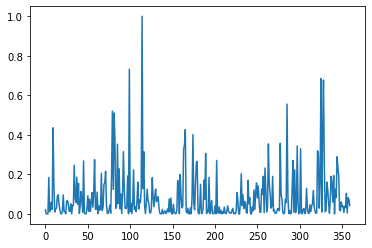

In [110]:
plt.plot(total_score)